# Algebraic Structures, Key Generators, and Reed Solomon/Goppa Codes for Cryptosystem Resilience

By Ivan von Greiff

This project will investigate the theory behind Code-Based Cryptosystems. We will specifically see how the McEliece Cryptosystem is designed, and investigate how knowing the algebraic structure of the code (Reed-Solomon and Goppa) helps us decode efficiently, while yielding a cryptographically resilient code. In the previous project, we saw how the resilience of asymmetric cryptography schemes are based on the "discrete logarithm" and "factoring of large numbers" problems. In this new project, the resilience of our cryptosystem is instead based on a different principle, namely the "NP-Hardness of decoding random codes." 

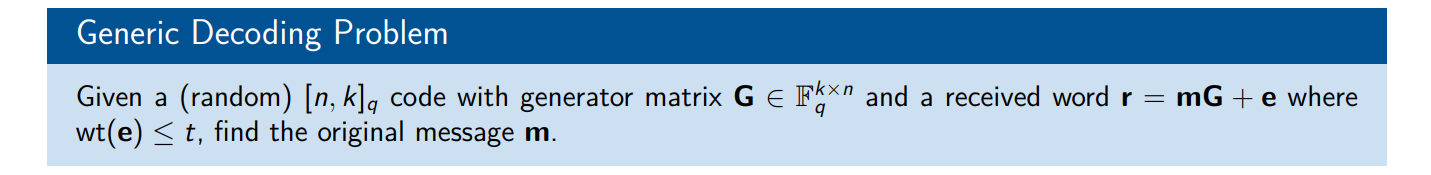

By hiding the algebraic structure of the code in scrambling the generator matrix, we can make a code with some algebraic structure (RS, Goppa, etc.) appear random and therefore intractable for a third party with access only to the ciphertext to decode. In the following diagram we see how the clean space of codewords gets purposefully distorted (with errors that we can correct - thanks to Reed Solomon and Goppa codes) in order to make the space looks more "random." The trick is that since we are able to correct these errors, we can reconstruct the original codeword-space.

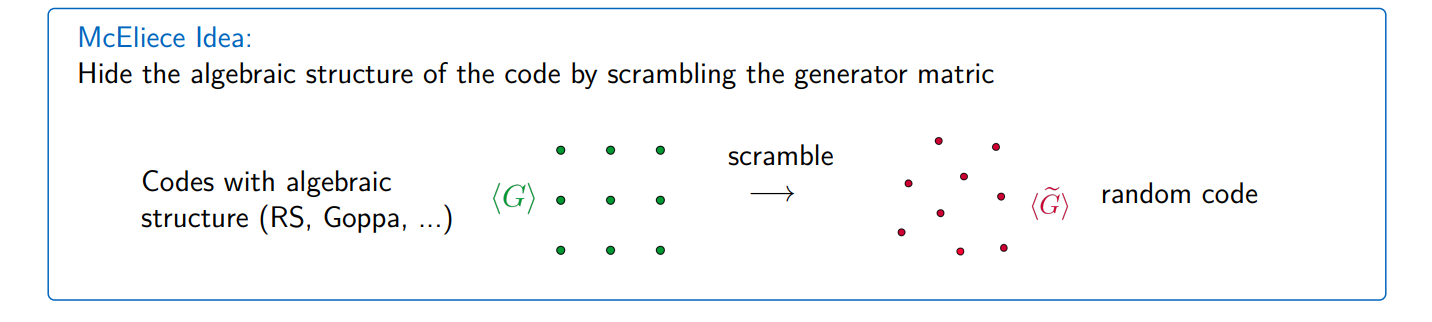

Within my program, I include notes for important concepts to help understand the significance behind the code, as well as mistakes I made when implementing the theory into SageMath.

The contents of my project are as follows:

1. SageMath, Primitive Elements, and Field Generation
2. Polynomials over Finite Fields
3. Linear Feedback Shift Register Key Generator
4. McEliece Key Generation
5. McEliece Encryption
6. McEliece Decryption and Decoding


# Task 1: Defining Field Elements

Finite Fields and Extension Fields are algebraic structures which are used both in cryptography (in algorithms such as the Advanced Encrypted Standard and Elliptic Curve Cryptography) and error detection/correction (via e.g. Reed Solomon codes). 

As a first exercise, we want to create the extension field $F_{2^4}$, a finite field with $2^4$ = 16 elements. Its primitive element should have the name $a$.

Next, we define two elements of $F_{2^4}$ in terms of the primitive element,  $e_1 = a^2 + 1$ and $e_2 = a^2 +a$

We then compute the logarithm of the elements, i.e., the value $i$ such that $a^i = e$. We can check our result by computing all powers of the primitive element $a$ and checking after how many multiplications $e$ occurs. 

Last, we want to check whether the elements $e_1$ and $e_2$ are primitive elements of the field. A primitive element is an element whose powers generate the entire field \(without zero\). 

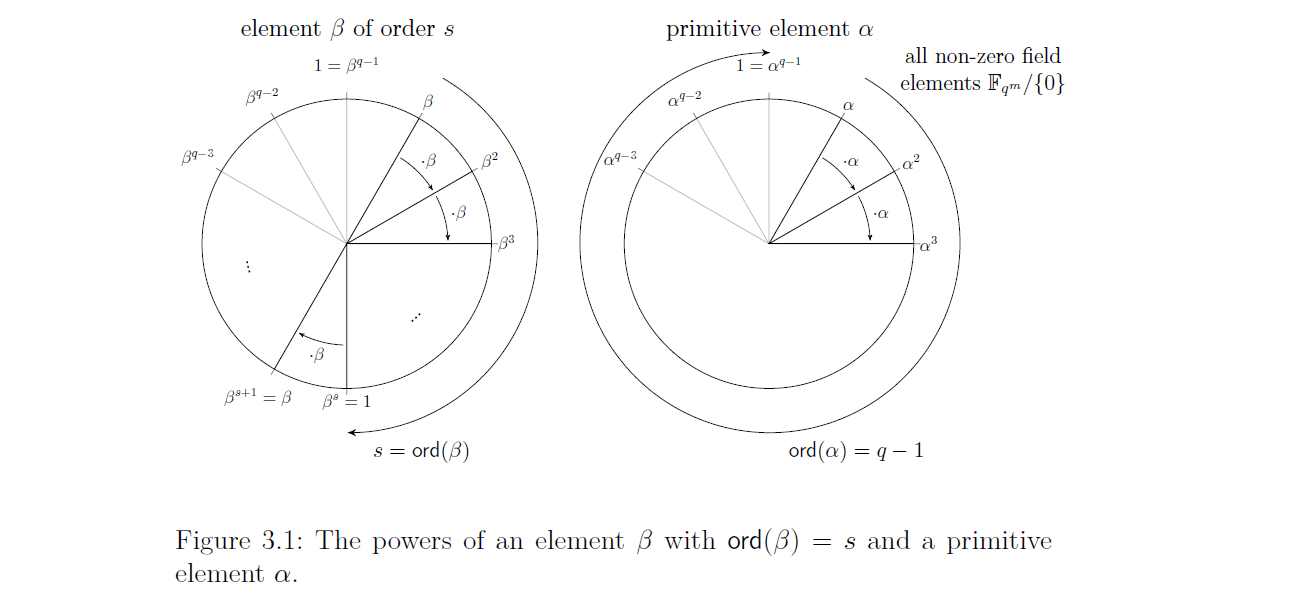


In [2]:
p = 2 # a prime number
m = 4 # The extension degree

### Define the extenstion field ###

F.<a> = GF(p**m)

### Define two field elements ###

e1 = a**2 + 1
e2 = a**2 + a

### compute the discrete logarithm ###

logarithm1 = log(e1,a)   # compute the logarithm of e1 with respect to a 
logarithm2 = log(e2,a)   # compute the logarithm of e2

### compute all powers of a ###

powers = a.powers(p**m -1)

### Find a method to check if our selected elements e1 and e2 are primitive elements of the field ###

def is_primitive(e):

    powers = set(e.powers(p**m -1))

    return len(powers) == (p**m - 1) 

In [3]:
# Test cases, do not modify. Make sure to rerun previous cell after making changes #

assert a**logarithm1 == e1, "logarithm of e1 is not correct."
assert a**logarithm2 == e2, "logarithm of e2 is not correct." 

assert len(powers) == p**m - 1, "a should have p**m -1 powers."
for i in range(p**m):
    assert a**(GF(p).random_element()) in powers, "some power of a is not in your list of powers." 

assert is_primitive(a**2 + 1), "e1 is primitive but your function claims it is not."
assert not is_primitive(a**2 + a), "e2 is not primitive but your function claims it is."
assert not is_primitive(a**2 + a + 1), "The polynomial a^2 + a + 1 is not primitive but your function claims it is."
print("All test cases passed")

All test cases passed


# TASK 2: Polynomials over Finite Fields

In the next task, we want to look at polynomials in $F_{q^m}[x]$, i.e., polynomials in $x$ whose coefficients come from $F_{q^m}$.

We start by generating the polynomial ring $G$ and then representing the following polynomial:

$g(x) = x^5 + a^2 x^4 + (a^3 + a^ 2 + a)x^3 +(a^3 + a^ 2 + a)x^2 + a^3x + a + 1$ 

where $a$ is the primitive element of the extension field as defined in the previous task.

First, extract the coefficients of g. (= A list of elements from $F_{q^m}$, make sure to get all of them not just the nonzero ones)
Next, find the roots of $g(x)$.

In [3]:
q = 2
m = 4

F.<a> = GF(q**m)
G.<x> = F[] 
# equivalently  G.<x> = PolynomialRing(F)

g = x^5 + a^2*x^4 + (a^3 + a^ 2 + a)*x^3 +(a^3 + a^ 2 + a)*x^2 + a^3*x + a + 1

coefficients = g.coefficients(sparse=false) # without sparse=false, the coefficients which are zero are removed from the list
roots = g.roots()

In [4]:
print('Coefficients of g:\t', coefficients)
print('Roots of g:\t\t', roots)

Coefficients of g:	 [a + 1, a^3, a^3 + a^2 + a, a^3 + a^2 + a, a^2, 1]
Roots of g:		 [(a + 1, 1), (a^2, 1), (a^2 + 1, 1), (a^3 + a + 1, 1), (a^3 + a^2 + 1, 1)]


# TASK 3: Revisiting LFSRs

In this task, we'll revisit the LFSR from Tutorial 1.

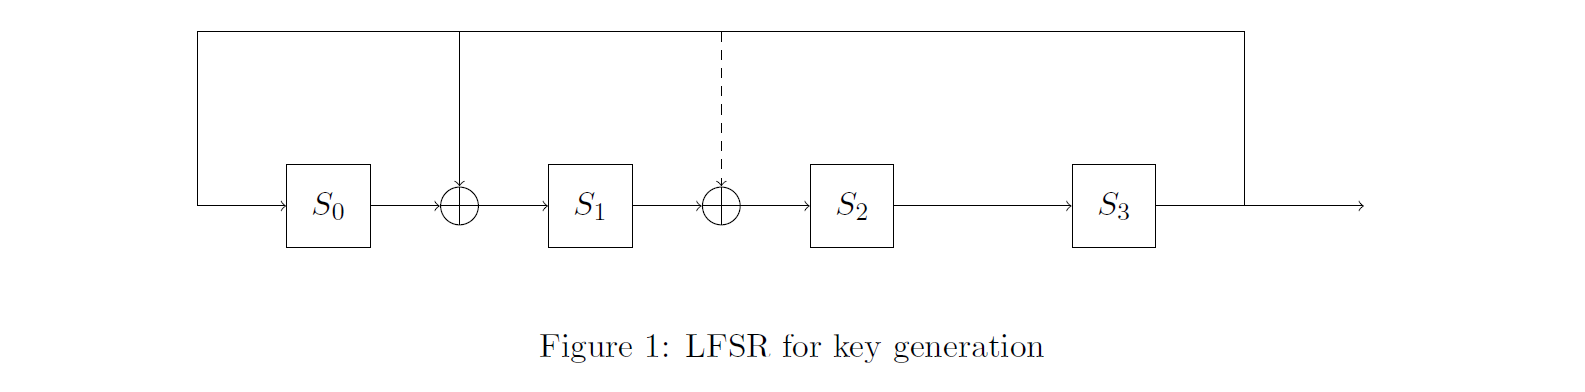

In the cell below, you are given a function that should simulate one shift operation of a LFSR given:
 - initial state [$s_0$, $s_1$, $s_2$, $s_3$] (provided as a list of integers, e.g. [$1$, $1$, $0$, $0$])
 - a list of "taps", i.e. the connections within the LFSR (provided as a list of integers, either $0$ or $1$ depending on if there is a connection between the output and the state at position $i$. The last entry is always 1 by convention and comes from the output itself). 

For example, the LFSR above has taps [$1$, $1$, $0$, $0$, $1$] without the dashed line and [$1$, $1$, $1$, $0$, $1$] with the dashed line.

The function should return the new state after one shift, as a list of integers [$s_0$, $s_1$, $s_2$, $s_3$], e.g. [$0$, $0$, $1$, $0$].

**Hint**: Use polynomials as in the tutorial! (it might be useful to look up the function "QuotientRing", but it can also be done without.)

In [5]:

def LFSR(initial_state, taps):
# initial state is a list of bitvalues for the registers [s0,s1,s2,s3], e.g. [1,1,1,0]
# taps is the list of feedback connections to the LFSR. In out example it's [1(input to s0), 1 (input to s1), 0, 0, 1(output)]

    F = GF(2)
    R.<x> = PolynomialRing(F)
    feedback_poly = R(taps)
    
    Q.<x> = QuotientRing(R,feedback_poly)
    state_poly = Q(initial_state)
        
    new_state = state_poly * x

    return new_state.list()
    

In [6]:
# Test cases, do not modify. Make sure to rerun previous cell after making changes #

def test_lfsr(feedback, initial_state, expect):
    state = initial_state
    reached_states = set()
    reached_states.add(tuple(state))
    output = [state[-1]]
    for i in range(14):
        state = LFSR(state, feedback)
        output.append(state[-1])
        reached_states.add(tuple(state))
    
    print("LFSR with feedback", feedback, ", Initial state", initial_state)
    print("Your output:\t\t", output)
    print("Expected output:\t", expect)
    print("Output correct?", output==expect)
    print("Cycle length:", len(reached_states))

test_lfsr(feedback=[1,1,0,0,1], initial_state = [1,1,0,0], expect = [0,0,1,1,0,1,0,1,1,1,1,0,0,0,1])
print("---------------------------------------")
test_lfsr(feedback=[1,1,1,0,1], initial_state = [1,0,0,1], expect = [1,0,1,0,0,1,1,1,0,1,0,0,1,1,1])

LFSR with feedback [1, 1, 0, 0, 1] , Initial state [1, 1, 0, 0]
Your output:		 [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Expected output:	 [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Output correct? True
Cycle length: 15
---------------------------------------
LFSR with feedback [1, 1, 1, 0, 1] , Initial state [1, 0, 0, 1]
Your output:		 [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Expected output:	 [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Output correct? True
Cycle length: 7


# Task 1: McEliece Cryptosystem

In this task, you are one of the encryptors (Alice or Bob). You will implement a toy version of the McEliece system with a $20$-error-correcting binary Goppa code of length $255$ over $\mathbb{F}_2$.

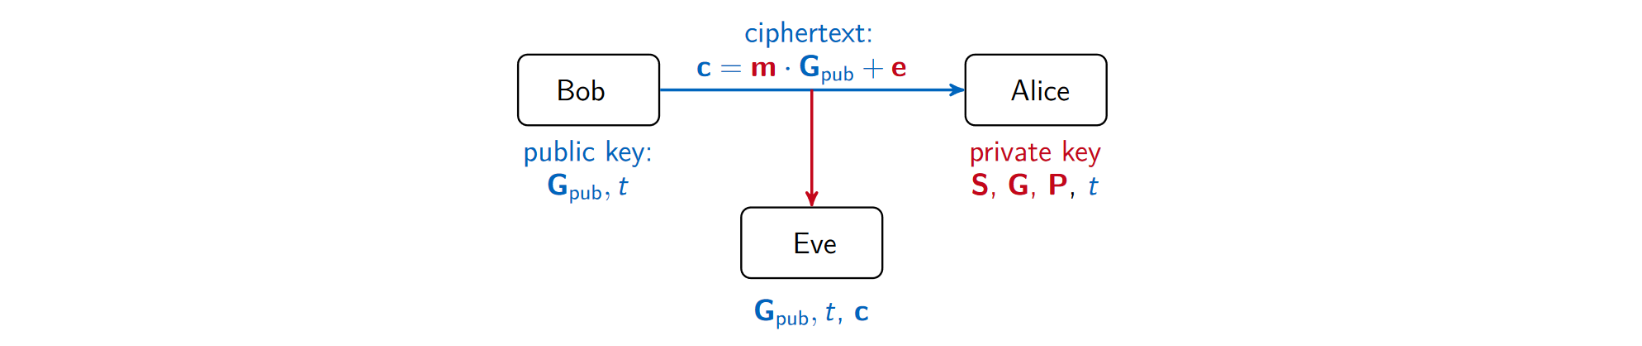

## Key generation

Implement the function keygen, which generates a random Goppa code to create a private/public keypair for the McEliece cryptosystem. 

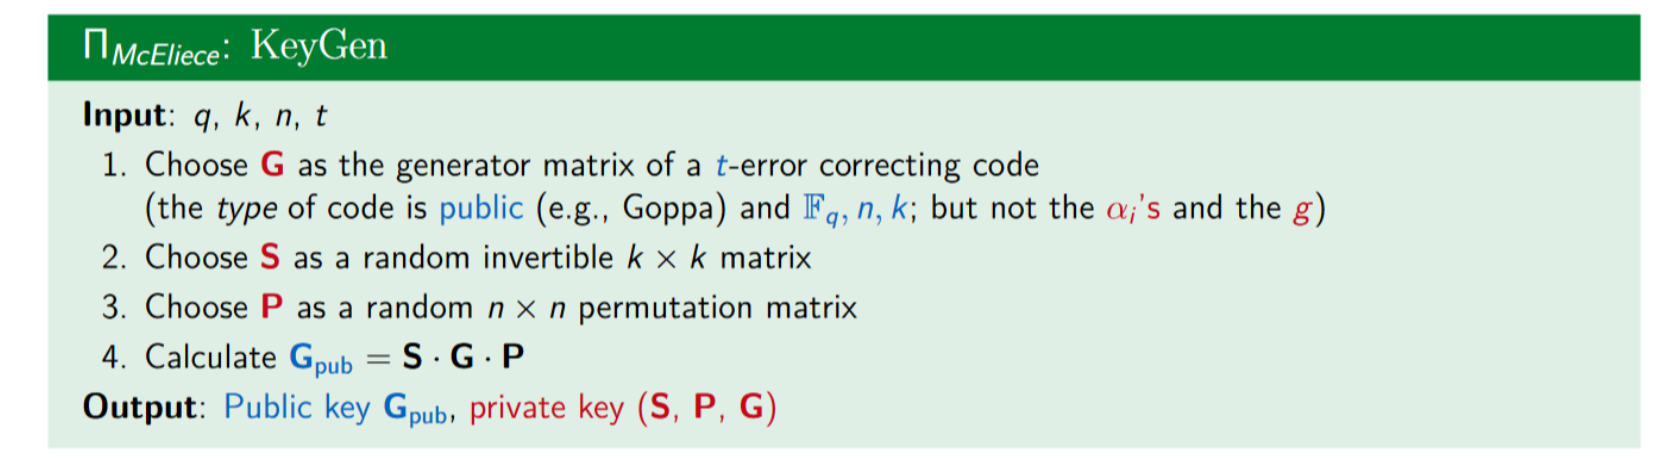

Input: 
- An integer $n$, the length of the used binary Goppa code
- An integer $t$, the error weight

Output: 
- A dictionary $sk$ that contains the secret key, i.e., the matrices $G$, $S$, $P$ and the Goppa code $GoppaC$.
- A dictionary $pk$ that contains the public key, i.e., the error weight $t$ and the matrix $G_{pub} = S\cdot G\cdot P$.

In [ ]:
def keygen(n,t):
    q = 2
    r = t # degree of Goppy polynomial for F_2
    m = ceil(log(n,2) + (r==1)) # extension degree, note that we may need a larger field for r = 1
    
    assert n-r*m > 0, "Increase the length or reduce the number of errors!"
    
    # generate Goppa code as a subfield subcode of a GRS code
    FE = GF(q^m)
    PR = PolynomialRing(FE, 'x')
    gpoly = PR.irreducible_element(t)**2
    locators = sample([a for a in FE if gpoly(a)],n)

    v = [gpoly(locators[i])/prod([locators[i]-locators[j] for j in range(n) if j != i]) for i in range(n)]

    RSC    = codes.GeneralizedReedSolomonCode(locators, n-2*r, v)
    GoppaC = codes.SubfieldSubcode(RSC, GF(2))
    
    # your code here
    G_sec = GoppaC.generator_matrix()
    k = G_sec.nrows()

    S_sec = random_matrix(GF(2), k, k)
    while S_sec.determinant() == 0:
        S_sec = random_matrix(GF(2), k, k)
    print("Is S_sec inv?")
    print(S_sec.determinant() != 0)

    #P_sec = matrix.identity(GF(2), n) 
    indices = list(range(n))
    shuffle(indices)  # Shuffle the list in place
    
    # Step 3: Create the permutation matrix
    P_sec = matrix(GF(2), n, n, lambda i, j: 1 if indices[i] == j else 0)

    print(S_sec.nrows())
    print(S_sec.ncols())
    print(G_sec.nrows())
    print(G_sec.ncols())
    print(P_sec.nrows())
    print(P_sec.ncols())
    
    G_pub = S_sec*G_sec*P_sec
    

    sk = {'G':G_sec, 'S':S_sec, 'P':P_sec, 'Goppa':GoppaC}
    pk = {'t':t, 'G':G_pub}
    
    return sk, pk

## Encryption

Next, we want to compute a cipthertext using reading Alice's public key.

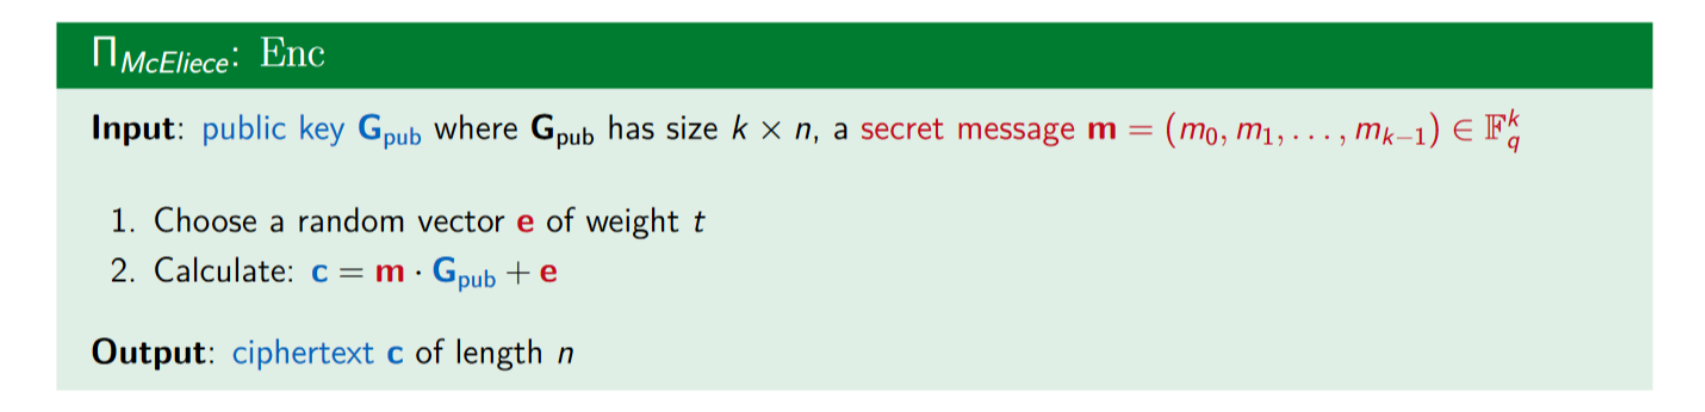

Input:
- message vector $m \in\mathbb{F}_2^k$
- Alices's public key $pk$

Output:
- ciphertext $y$
- used error positions $err\_pos$

In [ ]:
def encrypt(m, pk):

    # your code here
    # Initialize a vector 'e' which is of length 255 and has ones in t = 20 entries
    n = 255
    G_pub = pk['G']
    t = pk['t']
    vec = [1]*t + [0]*(n - t)
    shuffle(vec)
    e = vector(ZZ, vec)
    print(sum(e))
    y = m*G_pub+e
    err_pos = e
    
    return y, err_pos

## Decryption

Now, Alice wants to decrypt the ciphertext she receives from Bob.

*Hint:* use the given decoder of the Goppa code, with the option *decoder_name='OriginalCode'* to decode via the RS mother code.

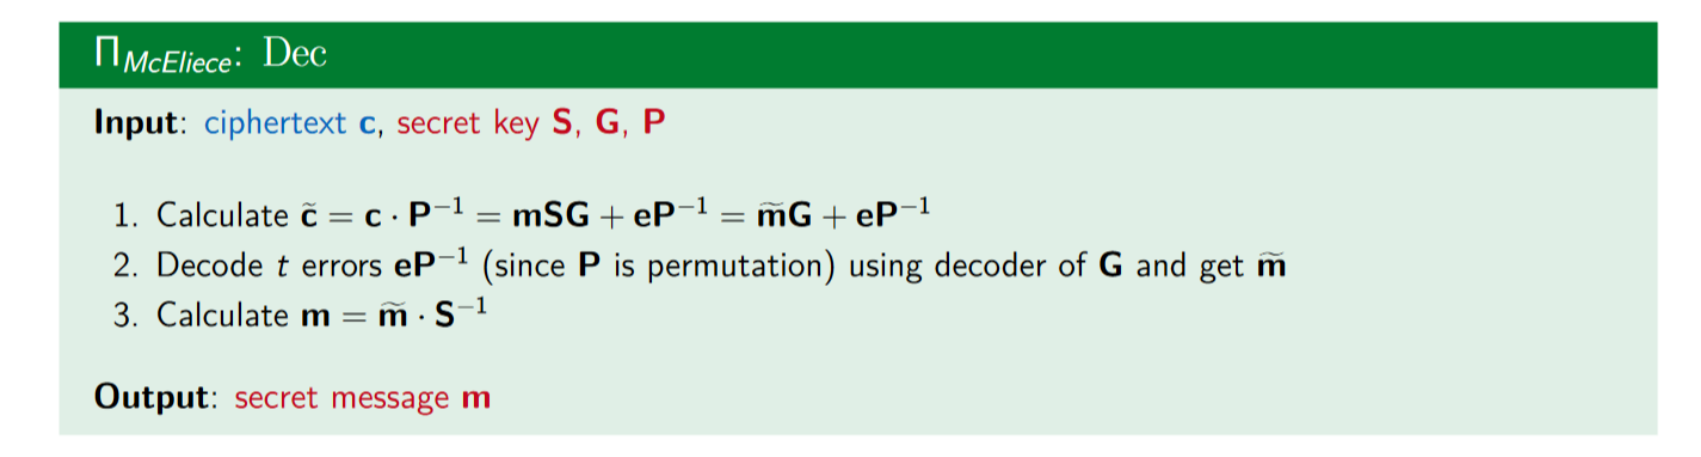

Input:
- vector $y\in\mathbb{F}_2^n$, the ciphertext.
- Alice's secret key $sk$.

Output:
- vector $m\_{hat}\in\mathbb{F}_2^k$, the decrypted message.


In [ ]:
def decrypt(y, sk):
    # Get the Goppa code from the secret key
    GoppaC = sk['Goppa']
    
    # Decode the received word using the decode_to_message method
    m_hat = GoppaC.decode_to_message(y, 'OriginalCode')
    
    return m_hat


In [ ]:
### Test cases ######
### S A N I T Y  C H E C K S ###

n = 255
t =  20

sk, pk = keygen(n,t)

assert pk['G'] == sk['S']*sk['G']*sk['P'], "keygen returned inconsistent matrices"

k =  pk['G'].dimensions()[0]
m = random_vector(GF(2), k) 
y, err_pos = encrypt(m, pk)

cw = m*pk['G']

assert sum(1 for i in range(n) if y[i]!=cw[i]) == t, "wrong error weight"

m_hat = decrypt(y, sk)
#print(m)
#print(m_hat)
assert m_hat == m, "decryption did not yield correct message"

print('congratulations, your McEliece system is working')

## Key Points
**Key Point 1)** Unlike the parent MDS code, the Goppa code is not MDS. How many errors could be corrected if it was MDS?

$\rightarrow$ If Goppa codes were Maximum-Distance Separable, they would also be able to correct the maximum number of errors (since each codeword would be placed at a maximum distance apart from each other in the code-space). Specifically, Goppa codes would inherit the error correction capability of Reed Solomon and be able to correct $\lfloor \frac{n-k}{2} \rfloor$ errors.

**Key Point 2)** For the present parameters, how many error patterns are possible?

$\rightarrow$ Given a code with length $n=255$ and the ability to correct up to $t=20$ errors present, we can have as many combinations that are possible when choosing up to $20$ concurrent positions from $255$ total positions. Therefore we sum the combinations from choosing $0$ to $20$ errors from $255$ positions as follows: $$ \sum_{i=1}^{20}\begin{pmatrix} 255 \\ i \end{pmatrix}
$$
